<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Collaborative Filtering Using a Neural Network
In this exercise we will demonstrate the use of neural network based recommendation system which uses a combination of content filtering and collaborative filtering to generate predicted ratings.  We will demonstrate this on a subset of the [MovieLens](https://grouplens.org/datasets/movielens/) dataset containing 100,000 movie ratings.  

In this approach, we create embeddings for each user, for each item, and for any features of the user or item that we have available.  To predict a rating of a user for an item, we concatenate the user embedding, the item embedding and any feature embeddings of the user and/or item.  We then feed the concatenated feature vector through a shallow neural network to generate the predicted rating.  A benefit of this approach is that by incorporating feature information about the user and/or item we can help solve the "cold start" problem we encounter when we add a new user to the system for whom we have no prior ratings or we add a new movie to the system which has not yet been rated by anyone.  As long as we have some feature information about the user or item we are adding, the feature embeddings should still hopefully enable us to generate a reasonable prediction.

**Notes:** 
- This should be run on GPU.  It can be run on CPU but will take ~30 minutes.

**References:**  
- Review the details on the MovieLens dataset [here](https://grouplens.org/datasets/movielens/)  

In [1]:
import os
import urllib
import zipfile
import time

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

## Prepare the data

In [2]:
# Download the data from the GroupLens website
datapath = './data/ml-latest-small'

if not os.path.exists('./data'):
    os.makedirs('./data')
if not os.path.exists(datapath):
    url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
    urllib.request.urlretrieve(url,filename='data/ml-latest-small.zip')
    zip_ref = zipfile.ZipFile('data/ml-latest-small.zip', 'r')
    zip_ref.extractall('data/')
    zip_ref.close()

In [3]:
# Load data
ratings = pd.read_csv(os.path.join(datapath,'ratings.csv'))
movies = pd.read_csv(os.path.join(datapath,'movies.csv'))
ratings = ratings.merge(movies,on='movieId')
ratings = ratings[['userId','movieId','genres','rating']]
ratings.head()

,userId,movieId,genres,rating
0,1,1,Adventure|Animation|Children|Comedy|Fantasy,4.0
1,5,1,Adventure|Animation|Children|Comedy|Fantasy,4.0
2,7,1,Adventure|Animation|Children|Comedy|Fantasy,4.5
3,15,1,Adventure|Animation|Children|Comedy|Fantasy,2.5
4,17,1,Adventure|Animation|Children|Comedy|Fantasy,4.5


As we can see above, our dataset consists of user IDs, movie IDs of movies they have rated, the genres of the movie, and the user's rating for each movie.  We will first encode the genres data to be able to use it in the model (we will use a simple numerical encoding for them).  We then split our data into the input data `X` (user IDs, movie IDs and genre) and the target `y` we are trying to predict (the ratings).  We will then split our data to create a validation set.

In [4]:
# Encode the genres data
encoder = LabelEncoder()
encoder.fit(ratings['genres'])
ratings['genres'] = encoder.transform(ratings['genres'])

In [5]:
X = ratings.loc[:,['userId','movieId','genres']]
y = ratings.loc[:,'rating']

# Split our data into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=0, test_size=0.2)

We can now put our data into PyTorch DataLoaders as we have done before with tabular data.

In [6]:
def prep_dataloaders(X_train,y_train,X_val,y_val,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train)).long(), 
                            torch.from_numpy(np.array(y_train)).float())
    valset = TensorDataset(torch.from_numpy(np.array(X_val)).long(), 
                            torch.from_numpy(np.array(y_val)).float())

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader

batchsize = 64
trainloader,valloader = prep_dataloaders(X_train,y_train,X_val,y_val,batchsize)

## Define model architecture
We will create our own architecture for our NN-based recommendation system.  It should include embedding layers for the users, items, and genres.  We then concatenate the user embedding, item embedding and genre embedding together.  We then pass the concatenated embedding for the user-item pair through two linear layers with a ReLu activation in between.  The output from the second linear layer is our prediction.  We commonly use a sigmoid function and scale the range of predictions to constrain it within our expected range (e.g. 0 to 5 stars).

In [7]:
class NNHybridFiltering(nn.Module):
    
    def __init__(self, n_users, n_items, n_genres, embdim_users, embdim_items, embdim_genres, n_activations, rating_range):
        super().__init__()
        self.user_embeddings = nn.Embedding(num_embeddings=n_users,embedding_dim=embdim_users)
        self.item_embeddings = nn.Embedding(num_embeddings=n_items,embedding_dim=embdim_items)
        self.genre_embeddings = nn.Embedding(num_embeddings=n_genres,embedding_dim=embdim_genres)
        self.fc1 = nn.Linear(embdim_users+embdim_items+embdim_genres,n_activations)
        self.fc2 = nn.Linear(n_activations,1)
        self.rating_range = rating_range

    def forward(self, X):
        # Get embeddings for minibatch
        embedded_users = self.user_embeddings(X[:,0])
        embedded_items = self.item_embeddings(X[:,1])
        embedded_genres = self.genre_embeddings(X[:,2])
        # Concatenate user, item and genre embeddings
        embeddings = torch.cat([embedded_users,embedded_items,embedded_genres],dim=1)
        # Pass embeddings through network
        preds = self.fc1(embeddings)
        preds = F.relu(preds)
        preds = self.fc2(preds)
        # Scale predicted ratings to target-range [low,high]
        preds = torch.sigmoid(preds) * (self.rating_range[1]-self.rating_range[0]) + self.rating_range[0]
        return preds
        


In [11]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5, scheduler=None):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    costpaths = {'train':[],'val':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Get the inputs and labels, and send to GPU if available
            for (inputs,labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs).view(-1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += np.sqrt(loss.item()) * labels.size(0)

            # Step along learning rate scheduler when in train
            if (phase == 'train') and (scheduler is not None):
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            costpaths[phase].append(epoch_loss)
            print('{} loss: {:.4f}'.format(phase, epoch_loss))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return costpaths

In [12]:
# Train the model
dataloaders = {'train':trainloader, 'val':valloader}
n_users = X.loc[:,'userId'].max()+1
n_items = X.loc[:,'movieId'].max()+1
n_genres = X.loc[:,'genres'].max()+1
model = NNHybridFiltering(n_users,
                       n_items,
                       n_genres,
                       embdim_users=50, 
                       embdim_items=50, 
                       embdim_genres=25,
                       n_activations = 100,
                       rating_range=[0.,5.])
criterion = nn.MSELoss()
lr=0.001
n_epochs=10
wd=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cost_paths = train_model(model,criterion,optimizer,dataloaders, device,n_epochs, scheduler=None)


Epoch 0/9
----------
train loss: 0.9640
val loss: 0.9252
Epoch 1/9
----------
train loss: 0.9017
val loss: 0.8910
Epoch 2/9
----------
train loss: 0.8692
val loss: 0.8703
Epoch 3/9
----------
train loss: 0.8509
val loss: 0.8606
Epoch 4/9
----------
train loss: 0.8353
val loss: 0.8543
Epoch 5/9
----------
train loss: 0.8226
val loss: 0.8482
Epoch 6/9
----------
train loss: 0.8113
val loss: 0.8466
Epoch 7/9
----------
train loss: 0.8016
val loss: 0.8457
Epoch 8/9
----------
train loss: 0.7920
val loss: 0.8435
Epoch 9/9
----------
train loss: 0.7847
val loss: 0.8480
Training complete in 0m 46s


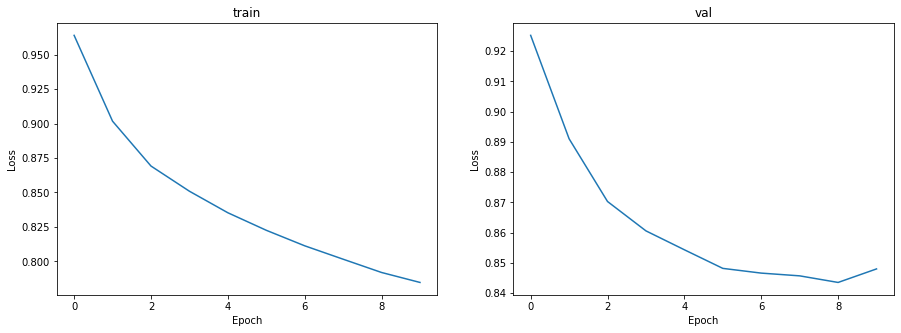

In [13]:
# Plot the cost over training and validation sets
fig,ax = plt.subplots(1,2,figsize=(15,5))
for i,key in enumerate(cost_paths.keys()):
    ax_sub=ax[i%3]
    ax_sub.plot(cost_paths[key])
    ax_sub.set_title(key)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()

## Get predicted rating for a user-movie pair
Now that our model is trained we can use it to generate predicted ratings of a given user for a given movie.  To do so we simply feed a user-item pair into our model and get the predicted rating.  We could also do other things such as determine which movie (out of all movies in our set) a particular user might rate the highest, and recommend that to him/her.

In [15]:
def predict_rating(model, userId, movieId, genre, encoder, device):
    # Encode genre
    genre = encoder.transform(np.array(genre).reshape(-1))
    # Get predicted rating
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        X = torch.Tensor([userId,movieId,genre]).long().view(1,-1)
        X = X.to(device)
        pred = model.forward(X)
        return pred

# Get the predicted rating for a random user-item pair
rating = predict_rating(model,userId=5,movieId=10,genre='Action|Adventure|Thriller',encoder=encoder, device=device)
print('Predicted rating is {:.1f}'.format(rating.detach().cpu().item()))

Predicted rating is 3.0


## Generate recommendations for user
Now that we have a trained model, we can use our model not only to predict a user's rating for a movie they have not seen but also to generate recommended movies for a user to watch.  The approach we will use to generate recommendations is as follows:  
1) Use our model to predict the rating a user will assign to every movie in the set
2) Sort the movies by predicted rating
3) Remove movies the user has already seen
4) Return the top predictions as the recommendations to watch

In [24]:
def generate_recommendations(movies,X,model,userId,encoder,device):
    # Get predicted ratings for every movie
    pred_ratings = []
    for movie in movies['movieId'].tolist():
        genre = movies.loc[movies['movieId']==movie,'genres']
        pred = predict_rating(model,userId,movie,genre,encoder,device)
        pred_ratings.append(pred.detach().cpu().item())
    # Sort movies by predicted rating
    idxs = np.argsort(np.array(pred_ratings))[::-1]
    recs = movies.iloc[idxs]['movieId'].values.tolist()
    # Filter out movies already watched by user
    movies_watched = X.loc[X['userId']==userId, 'movieId'].tolist()
    recs = [rec for rec in recs if not rec in movies_watched]
    # Filter to top 10 recommendations
    recs = recs[:10]
    # Convert movieIDs to titles
    recs_names = []
    for rec in recs:
        recs_names.append(movies.loc[movies['movieId']==rec,'title'].values[0])
    return recs_names


In [25]:
# Get recommendations for a random user
userId = 5
movies = pd.read_csv(os.path.join(datapath,'movies.csv'))
recs = generate_recommendations(movies,X,model,userId,encoder,device)
for i,rec in enumerate(recs):
  print('Recommendation {}: {}'.format(i,rec))

Recommendation 0: Paths of Glory (1957)
Recommendation 1: Inside Job (2010)
Recommendation 2: Man Bites Dog (C'est arrivé près de chez vous) (1992)
Recommendation 3: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
Recommendation 4: Monty Python and the Holy Grail (1975)
Recommendation 5: Gallipoli (1981)
Recommendation 6: Three Billboards Outside Ebbing, Missouri (2017)
Recommendation 7: Godfather: Part II, The (1974)
Recommendation 8: Fight Club (1999)
Recommendation 9: Reservoir Dogs (1992)
